# LeNet

In [248]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
import numpy as np


%matplotlib inline

In [249]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## data

In [250]:
T = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [251]:
train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [252]:
print('train data shape: ', train_data.data.shape)
print('train targets shape: ', train_data.targets.shape)
print('test data shape: ', test_data.data.shape)
print('test targets shape: ', test_data.targets.shape)

train data shape:  torch.Size([60000, 28, 28])
train targets shape:  torch.Size([60000])
test data shape:  torch.Size([10000, 28, 28])
test targets shape:  torch.Size([10000])


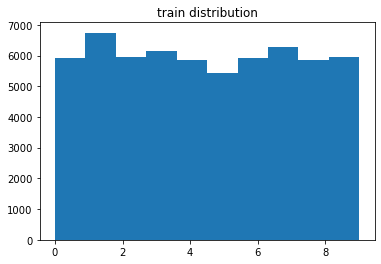

In [253]:
plt.title('train distribution')
plt.hist(train_data.targets);

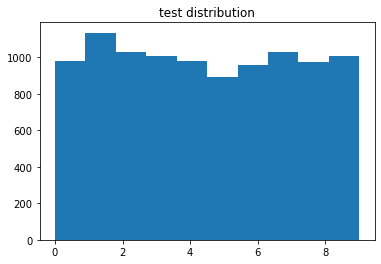

In [254]:
plt.title('test distribution')
plt.hist(test_data.targets);

In [255]:
num, height, width = np.array(train_data.data).shape
num, height, width

(60000, 28, 28)

### normalization

In [256]:
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_min, img_max

(0, 255)

In [257]:
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_norm_mean

0.1306604762738429

In [258]:
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
img_std

0.3081078038564622

In [259]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((img_norm_mean,), (img_std,)) 
])
train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

In [260]:
batch_size = 8 # number of training examples present in a single batch

In [261]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [262]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 7, 1, 7, 0, 6, 7, 9])


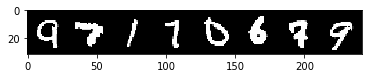

In [264]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [18]:
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=3, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, 
                               out_channels=5, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(5 * 22 * 22, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 5 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x
"""

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(in_channels=1, \n                               out_channels=3, \n                               kernel_size=5, \n                               padding=0)\n        self.conv2 = nn.Conv2d(in_channels=3, \n                               out_channels=5, \n                               kernel_size=3, \n                               padding=0)\n        self.fc1 = nn.Linear(5 * 22 * 22, 128) \n        self.fc2 = nn.Linear(128, 10)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x))\n        x = F.relu(self.conv2(x))\n        x = x.view(-1, 5 * 22 * 22)\n        x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        return x\n    \n    def features_2(self, x):\n        x = F.relu(self.conv1(x))\n        x = F.relu(self.conv2(x))\n        return x\n    \n    def features_1(self, x):\n        x = F.relu(self.conv1(x))\n        return x\n'

## LeNet
![wtf](images\LeNet_Original_Image.jpg)
The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier.

In [265]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5,
                               padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)
        
        #fully connected layers
        ## convert matrix with 8*5*5 (= 200) features to a matrix of 120 features (columns)
        self.fc1 = nn.Linear(in_features=8*5*5,
                             out_features=120) 
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84, 
                             out_features=10)

    def forward(self, x):
        
        # convolve, then perform ReLU non-linearity
        # max-pooling with 2x2 grid 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # flattening convolutional layer
        x = x.view(-1, 8 * 5 * 5)
        
        # fully-connected layers + perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

In [266]:
model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [267]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [268]:
torch.manual_seed(123)

In [269]:
epochs = 15
log_interval = 1000
iterations = len(train_loader.dataset)//batch_size

x = list(range(1, epochs + 1))
training_loss_list = []
validation_loss_list = []
validation_accuracy_list = []


In [270]:
print("training set size                ", len(train_loader.dataset))
print("validation set size              ", len(test_loader.dataset))
print("batch size (training/validation) ", batch_size)
print("iterations in epoch              ", iterations)

training set size                 60000
validation set size               10000
batch size (training/validation)  8
iterations in epoch               7500


In [271]:
%%time

for epoch in range(epochs): # entire dataset is passed forward and backward through the nn
    model.train()
    
    epoch_training_loss = 0
    accuracy = 0
    num_batches = 0
    
    print("=== epoch %2d ===" % (epoch + 1))
    
    for batch_idx, training_batch in enumerate(train_loader, 0):        
        inputs, labels = training_batch[0].to(device), training_batch[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        
        #backward propagation
        loss.backward()
        
        # Update the parameters(weight,bias)
        optimizer.step()
        
        epoch_training_loss += loss.item()# .data
        num_batches+=1
        
        
        if batch_idx % log_interval == log_interval - 1:
            # iteration = batch_size(8) * batch_idx
            
            validation_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                model.eval()
                for val_data in test_loader:
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_inputs)
                    
                    # validation loss
                    val_loss = loss_function(val_outputs, val_labels)
                    validation_loss += val_loss.item()
                    
                    # validation accuracy
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()
                                    
            #epoch_training_loss /= log_interval
            #validation_loss /= log_interval
            print("    iteration [%4d/%4d] training loss %.3f validation loss %.3f validation accuracy %.3f" % (
                batch_idx + 1,
                #batch_idx * len(data), 
                len(train_loader.dataset)/batch_size,
                epoch_training_loss / batch_idx,
                validation_loss / log_interval,
                100*correct/total))

            
            model.train()
                    
    epoch_training_loss /= iterations
    validation_loss /= log_interval
    validation_accuracy = 100*correct/total

    print("epoch training loss       %.3f"% (epoch_training_loss))
    print("epoch validation loss     %.3f"% (validation_loss))
    print("epoch validation accuracy %.3f"% (validation_accuracy))
    
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    
    #epoch_training_loss = 0
    

=== epoch  1 ===
    iteration [1000/7500] training loss 2.293 validation loss 2.838 validation accuracy 17.850
    iteration [2000/7500] training loss 2.261 validation loss 2.682 validation accuracy 47.960
    iteration [3000/7500] training loss 2.105 validation loss 1.500 validation accuracy 67.310
    iteration [4000/7500] training loss 1.787 validation loss 0.736 validation accuracy 83.000
    iteration [5000/7500] training loss 1.539 validation loss 0.564 validation accuracy 86.630
    iteration [6000/7500] training loss 1.359 validation loss 0.506 validation accuracy 87.870
    iteration [7000/7500] training loss 1.221 validation loss 0.440 validation accuracy 88.990
epoch training loss       1.167
epoch validation loss     0.440
epoch validation accuracy 88.990
=== epoch  2 ===
    iteration [1000/7500] training loss 0.343 validation loss 0.377 validation accuracy 90.610
    iteration [2000/7500] training loss 0.331 validation loss 0.349 validation accuracy 91.360
    iteration 

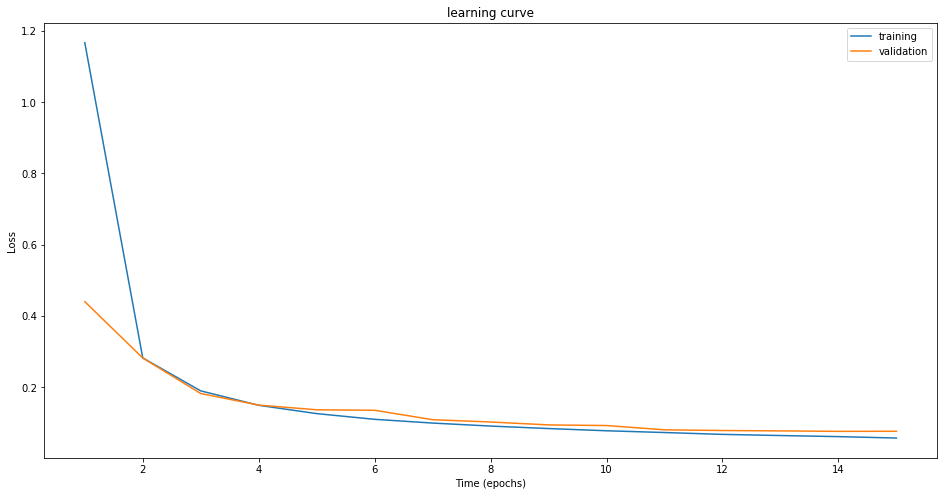

In [272]:
plt.figure(figsize=(16,8))
plt.title("learning curve")
plt.plot(x, training_loss_list, label= 'training')
plt.plot(x, validation_loss_list, label= 'validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Loss")
plt.legend();

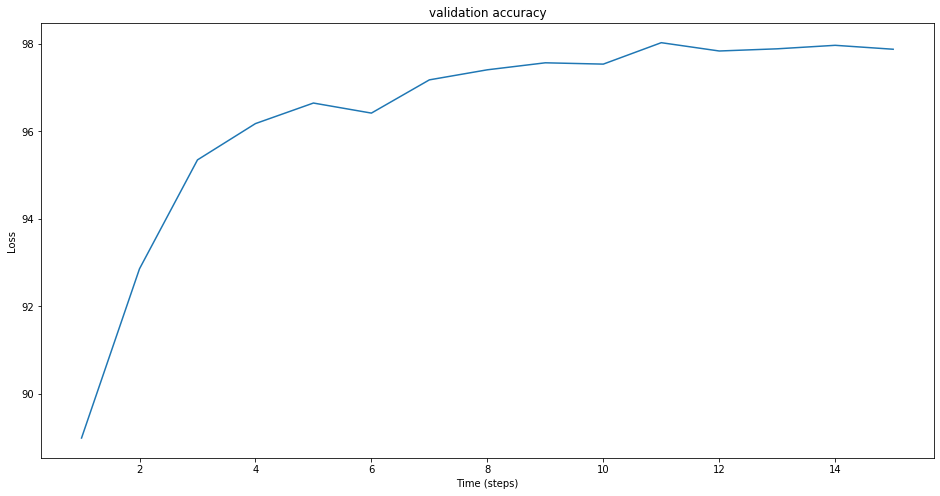

In [273]:
plt.figure(figsize=(16,8))
plt.title("validation accuracy")
plt.plot(x, validation_accuracy_list)
plt.xlabel("Time (steps)")
plt.ylabel("Loss");

In [274]:
def show_features(features):
    if len(features.shape) < 4:
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        print("batch ", batch)
        print("num_feature: ", num_feature)
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1, )
                
                plt.imshow(feature.numpy(), cmap = 'gray')
                

batch  8
num_feature:  4


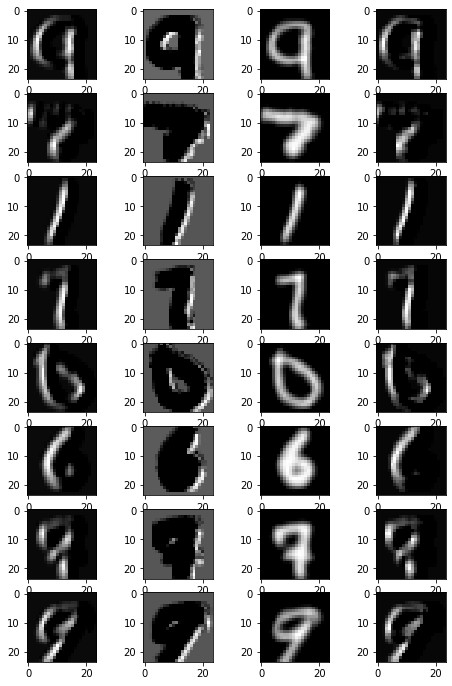

In [275]:
plt.figure(figsize=(8,12))
show_features(model.features_1(images.to(device)).detach().cpu())

batch  8
num_feature:  8


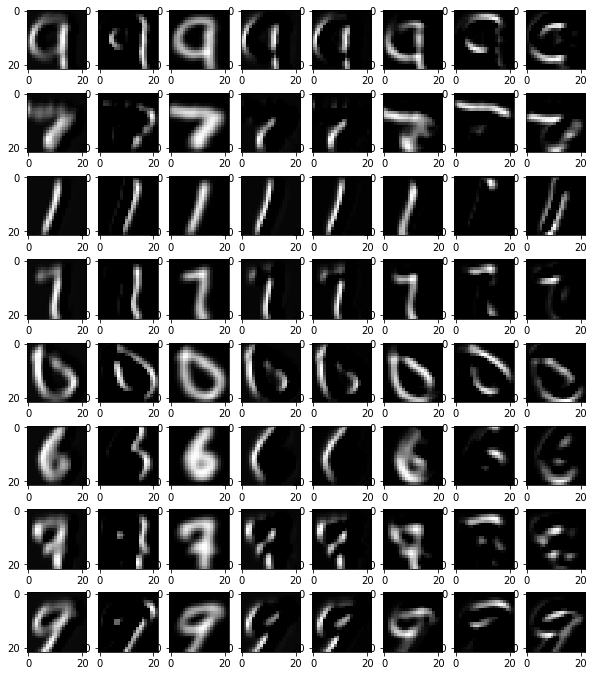

In [276]:
plt.figure(figsize=(10,12))
show_features(model.features_2(images.to(device)).detach().cpu())

## misclassified digits
### confusion matrix

In [278]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

#print(confusion_matrix)

In [279]:
confusion_matrix.shape

torch.Size([10, 10])

In [280]:
confusion_matrix = confusion_matrix.numpy()

In [281]:
confusion_matrix = confusion_matrix.astype('int32')

In [282]:
confusion_matrix

array([[ 977,    0,    0,    1,    0,    0,    0,    1,    1,    0],
       [   0, 1129,    2,    1,    0,    0,    0,    2,    1,    0],
       [   6,    1, 1003,    3,    1,    0,    0,   16,    2,    0],
       [   0,    0,    1,  995,    1,    0,    0,    6,    2,    5],
       [   1,    1,    2,    0,  967,    0,    3,    3,    1,    4],
       [   3,    0,    0,    9,    1,  870,    3,    1,    3,    2],
       [   5,    4,    0,    1,    1,    3,  942,    0,    2,    0],
       [   1,    3,    4,    1,    0,    0,    0, 1014,    1,    4],
       [   9,    1,    7,    2,    1,    1,    2,    8,  940,    3],
       [   6,    5,    0,    4,    4,    0,    0,   18,    0,  972]])

In [283]:
import pandas as pd
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

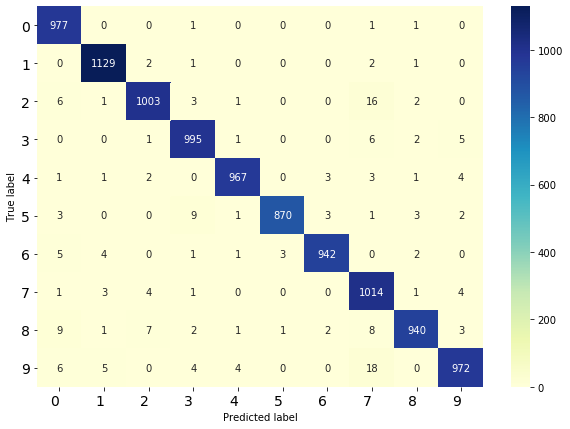

In [284]:
fig = print_confusion_matrix(confusion_matrix, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], figsize = (10,7), fontsize=14)

## errors
- 0 ~ 9
- 2 ~ 8
- 2 ~ 7
- 3 ~ 9
- 4 ~ 9
- 5 ~ 6
- 7 ~ 9

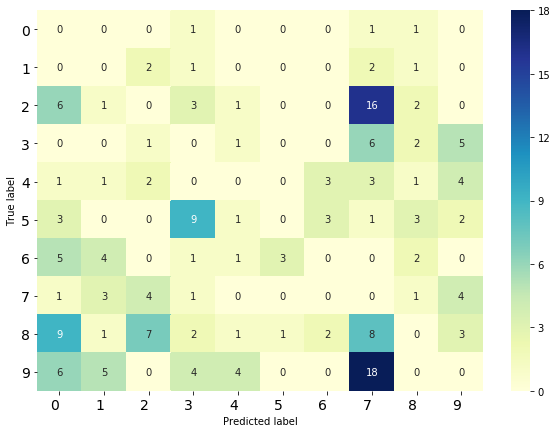

In [285]:
confusion_matrix[np.diag_indices_from(confusion_matrix)] = 0
fig = print_confusion_matrix(confusion_matrix, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], figsize = (10,7), fontsize=14)

## kaggle 
https://www.kaggle.com/c/digit-recognizer/overview
![wtf](images\submissions.jpg)